# Generative AI Evaluation Workshop

Welcome! This notebook complements the interactive presentation on evaluation metrics for Generative AI.

You'll practice with:
- **N-gram metrics** (BLEU, ROUGE)
- **Embedding-based metrics** (BERTScore)
- **Learned metrics** (BLEURT)
- **Human evaluation** using the MQM framework

Each section provides guidance, code, and space for your own experiments.

## Section 1: Setup
Install and import the libraries we'll use. If you're in Google Colab, just run the cell below.

In [17]:
!pip -q install nltk rouge-score matplotlib seaborn bert-score pandas transformers --upgrade

In [18]:
from transformers import pipeline

try:
    llm_pipeline = pipeline("text2text-generation", model="google/flan-t5-small") # Define the model you want to use
    print("LLM (Flan-T5) cargado con éxito.")
    llm_available = True
except Exception as e:
    print(f"No se pudo cargar el LLM: {e}")
    print("Los ejemplos subsiguientes usarán texto estático.")
    llm_available = False

def generate_with_llm(prompt):
    if llm_available:
        # Generate text using the LLM
        response = llm_pipeline(prompt, max_length=50, do_sample=False)
        return response[0]['generated_text']
    else:
        return ""

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


LLM (Flan-T5) cargado con éxito.


In [19]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
try:
    from bert_score import score
    bertscore_available = True
    print('BERTScore available!')
except ImportError:
    print('BERTScore not available - will use simulated scores')
    bertscore_available = False
nltk.download('punkt')
nltk.download('punkt_tab')
print('Setup complete.')

BERTScore available!
Setup complete.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Section 2: N-gram Metrics - BLEU & ROUGE
BLEU measures n-gram precision between a candidate text and one or more reference texts.
ROUGE focuses more on recall and is commonly used for summarization.

**Key insights:**
- Simple, fast, and reproducible
- But insensitive to synonyms and paraphrases

In [6]:
from nltk.tokenize import word_tokenize

def compute_bleu(candidate: str, references: list, weights=(0.25, 0.25, 0.25, 0.25)):
    """
    Compute BLEU score for one candidate against one or more references.
    - candidate: string
    - references: list of strings
    - weights: tuple for 1- to 4-gram weights (default uniform)
    """
    cand_tokens = word_tokenize(candidate.lower())
    ref_tokens_list = [word_tokenize(r.lower()) for r in references]
    smoothie = SmoothingFunction().method1
    score = sentence_bleu(ref_tokens_list, cand_tokens, weights=weights, smoothing_function=smoothie)
    return score

def compute_rouge(ref: str, pred: str):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(ref, pred)
    return {k: {'precision': v.precision, 'recall': v.recall, 'f1': v.fmeasure} for k, v in scores.items()}

# Demo
candidate = 'The cat is on the mat'
references = ['There is a cat on the mat', 'The cat sits on the mat']
print('BLEU demo:', compute_bleu(candidate, references))
print('ROUGE demo:', compute_rouge(references[0], candidate))

BLEU demo: 0.2659147948472494
ROUGE demo: {'rouge1': {'precision': 0.8333333333333334, 'recall': 0.7142857142857143, 'f1': 0.7692307692307692}, 'rougeL': {'precision': 0.6666666666666666, 'recall': 0.5714285714285714, 'f1': 0.6153846153846153}}


### Exercise 2.1: N-gram Metrics Exploration
Enter your own candidate and references. Try small edits (word order, synonyms) and observe how BLEU and ROUGE behave.
**Time:** 7 minutes

In [22]:
#@title Enter your texts
candidate_text = 'I love machine learning'  #@param {type: 'string'}
references_text = 'I enjoy machine learning | I love ML'  #@param {type: 'string'}
weights_choice = 'uniform_4gram'  #@param ['uniform_4gram', 'up_to_bigrams']

if weights_choice == 'uniform_4gram':
    weights = (0.25, 0.25, 0.25, 0.25)
else:
    weights = (0.5, 0.5, 0.0, 0.0)

references_list = [s.strip() for s in references_text.split('|') if s.strip()]
print('Candidate:', candidate_text)
print('References:', references_list)
print('Weights:', weights)
print()
print('BLEU:', compute_bleu(candidate_text, references_list, weights=weights))
rouge_scores = compute_rouge(references_list[0], candidate_text)
print('ROUGE-1 F1:', rouge_scores['rouge1']['f1'])
print('ROUGE-L F1:', rouge_scores['rougeL']['f1'])

Candidate: I love machine learning
References: ['I enjoy machine learning', 'I love ML']
Weights: (0.25, 0.25, 0.25, 0.25)

BLEU: 0.24028114141347542
ROUGE-1 F1: 0.75
ROUGE-L F1: 0.75


### Exercise 2.2: Compare Two Summaries
Given a source text, evaluate two summaries using ROUGE-1 and ROUGE-L and interpret results.
**Time:** 8 minutes

Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


ROUGE for Summary A: {'rouge1': {'precision': 0.8571428571428571, 'recall': 0.42857142857142855, 'f1': 0.5714285714285714}, 'rougeL': {'precision': 0.8571428571428571, 'recall': 0.42857142857142855, 'f1': 0.5714285714285714}}
ROUGE for Summary B: {'rouge1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'rougeL': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}


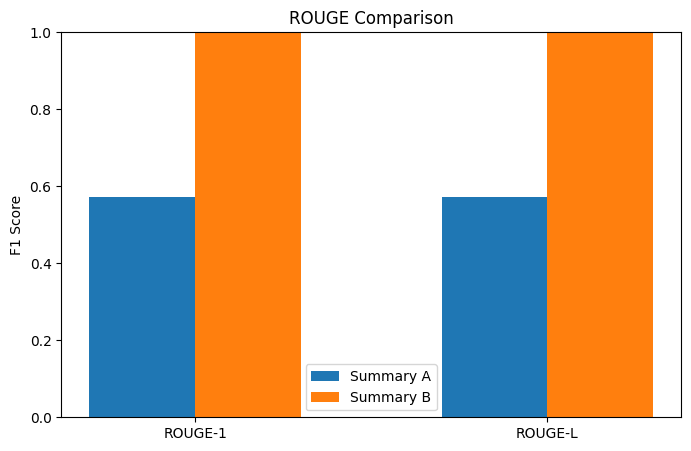

In [23]:
#@title Enter source and summaries
source_text = 'Artificial intelligence is transforming how we work, learn, and communicate in the modern world.'  #@param {type: 'string'}
summary_a = 'AI transforms how we work and communicate.'  #@param {type: 'string'}

#summary_b = 'Technology is changing everything.'  #@param {type: 'string'}
prompt_b = f"Summarize the following text in one sentence: '{source_text}'"
summary_b = generate_with_llm(prompt_b)

scores_a = compute_rouge(source_text, summary_a)
scores_b = compute_rouge(source_text, summary_b)
print('ROUGE for Summary A:', scores_a)
print('ROUGE for Summary B:', scores_b)

# Simple visualization for F1
labels = ['ROUGE-1', 'ROUGE-L']
a_f1 = [scores_a['rouge1']['f1'], scores_a['rougeL']['f1']]
b_f1 = [scores_b['rouge1']['f1'], scores_b['rougeL']['f1']]
x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([i-0.15 for i in x], a_f1, width=0.3, label='Summary A')
plt.bar([i+0.15 for i in x], b_f1, width=0.3, label='Summary B')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('F1 Score')
plt.title('ROUGE Comparison')
plt.legend()
plt.show()

## Section 3: BERTScore - Embedding-based Evaluation
BERTScore uses contextual embeddings to capture semantic meaning and handle paraphrases better than n-gram metrics.

**Key advantages:**
- Understands synonyms ("movie" vs "film")
- Captures semantic similarity
- Higher correlation with human judgment

In [9]:
def compute_bertscore(references, candidates, lang='en'):
    if bertscore_available:
        P, R, F1 = score(candidates, references, lang=lang, verbose=False)
        return {'precision': P.mean().item(), 'recall': R.mean().item(), 'f1': F1.mean().item()}
    else:
        # Simulated scores for demo purposes
        import random
        random.seed(hash(candidates[0]) % 1000)  # Deterministic but varied

        # Simulate better semantic understanding
        ref_words = set(references[0].lower().split())
        cand_words = set(candidates[0].lower().split())

        # Basic overlap
        overlap = len(ref_words & cand_words) / len(ref_words | cand_words) if ref_words | cand_words else 0

        # Semantic bonuses (simulating BERT understanding)
        semantic_bonus = 0
        if ('movie' in references[0].lower() and 'film' in candidates[0].lower()) or \
           ('film' in references[0].lower() and 'movie' in candidates[0].lower()):
            semantic_bonus += 0.15
        if ('excellent' in references[0].lower() and 'great' in candidates[0].lower()) or \
           ('great' in references[0].lower() and 'excellent' in candidates[0].lower()):
            semantic_bonus += 0.1

        base_score = min(0.95, overlap * 0.7 + semantic_bonus + 0.2)
        noise = (random.random() - 0.5) * 0.05

        final_score = max(0.1, base_score + noise)
        return {
            'precision': final_score + random.random() * 0.05,
            'recall': final_score + random.random() * 0.05,
            'f1': final_score
        }

# Demo
ref = ['The movie was excellent.']
cand1 = ['The film was excellent.']  # Should score high (synonyms)
cand2 = ['The movie was terrible.']  # Should score lower (opposite meaning)
print('BERTScore for synonymous text:', compute_bertscore(ref, cand1))
print('BERTScore for different meaning:', compute_bertscore(ref, cand2))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore for synonymous text: {'precision': 0.9920729398727417, 'recall': 0.9920729398727417, 'f1': 0.9920729398727417}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore for different meaning: {'precision': 0.977084219455719, 'recall': 0.977084219455719, 'f1': 0.977084219455719}


### Exercise 3.1: Compare BERTScore with BLEU/ROUGE
Test how BERTScore handles paraphrases and synonyms compared to n-gram metrics.
**Time:** 7 minutes

Reference: "The car is red."

Comparing metrics on challenging examples:



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1: "The automobile is red."
  BLEU: 0.286
  ROUGE-1 F1: 0.750
  BERTScore F1: 0.979



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 2: "Red is the car."
  BLEU: 0.143
  ROUGE-1 F1: 1.000
  BERTScore F1: 0.927



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 3: "The car is blue."
  BLEU: 0.286
  ROUGE-1 F1: 0.750
  BERTScore F1: 0.987



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 4: "The vehicle has a red color."
  BLEU: 0.043
  ROUGE-1 F1: 0.400
  BERTScore F1: 0.949



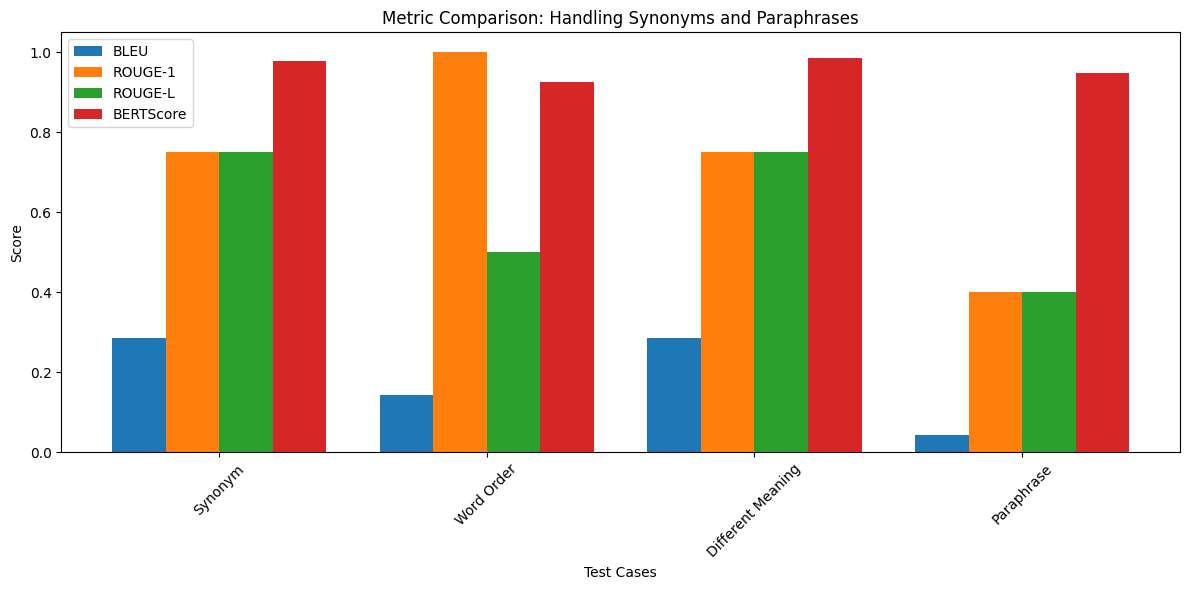

In [10]:
# Test cases that challenge n-gram metrics
reference = 'The car is red.'
candidates = [
    'The automobile is red.',      # Synonym
    'Red is the car.',             # Word order change
    'The car is blue.',            # Different meaning
    'The vehicle has a red color.' # Paraphrase
]

print(f'Reference: "{reference}"\n')
print('Comparing metrics on challenging examples:\n')

results = []
for i, cand in enumerate(candidates, 1):
    bleu = compute_bleu(cand, [reference])
    rouge = compute_rouge(reference, cand)
    bert = compute_bertscore([reference], [cand])

    results.append({
        'Candidate': cand,
        'BLEU': bleu,
        'ROUGE-1': rouge['rouge1']['f1'],
        'ROUGE-L': rouge['rougeL']['f1'],
        'BERTScore': bert['f1']
    })

    print(f'Example {i}: "{cand}"')
    print(f'  BLEU: {bleu:.3f}')
    print(f'  ROUGE-1 F1: {rouge["rouge1"]["f1"]:.3f}')
    print(f'  BERTScore F1: {bert["f1"]:.3f}')
    print()

# Visualize the comparison
df = pd.DataFrame(results)
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L', 'BERTScore']
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(candidates))
width = 0.2

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric)

ax.set_xlabel('Test Cases')
ax.set_ylabel('Score')
ax.set_title('Metric Comparison: Handling Synonyms and Paraphrases')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Synonym', 'Word Order', 'Different Meaning', 'Paraphrase'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

## Section 4: BLEURT - Learned Evaluation Metric
BLEURT is trained to predict human judgments and typically correlates better with human evaluation than other automatic metrics.

**Key advantages:**
- Highest correlation with human judgments
- Robust to noise and edge cases
- Can be customized for specific tasks

In [11]:
def compute_bleurt_simulation(reference, candidate):
    """
    Simulated BLEURT scores based on heuristics.
    In practice, you'd use the actual BLEURT model.
    This simulation tries to mimic BLEURT's behavior.
    """
    import random
    random.seed(hash(candidate) % 1000)  # Deterministic but varied

    # Base similarity (length and word overlap)
    ref_words = set(reference.lower().split())
    cand_words = set(candidate.lower().split())
    overlap = len(ref_words & cand_words) / len(ref_words | cand_words) if ref_words | cand_words else 0

    # Length penalty/bonus
    len_ratio = min(len(candidate), len(reference)) / max(len(candidate), len(reference))

    # Simulated semantic understanding (would be actual BERT in real BLEURT)
    semantic_bonus = 0

    # Synonym handling
    synonyms = [
        ('excellent', 'great'), ('movie', 'film'), ('car', 'automobile'),
        ('delicious', 'tasty'), ('restaurant', 'eatery')
    ]

    for syn1, syn2 in synonyms:
        if (syn1 in reference.lower() and syn2 in candidate.lower()) or \
           (syn2 in reference.lower() and syn1 in candidate.lower()):
            semantic_bonus += 0.15

    # Sentiment alignment
    positive_words = ['excellent', 'great', 'good', 'delicious', 'wonderful']
    negative_words = ['terrible', 'bad', 'awful', 'poor']

    ref_positive = any(word in reference.lower() for word in positive_words)
    ref_negative = any(word in reference.lower() for word in negative_words)
    cand_positive = any(word in candidate.lower() for word in positive_words)
    cand_negative = any(word in candidate.lower() for word in negative_words)

    if (ref_positive and cand_positive) or (ref_negative and cand_negative):
        semantic_bonus += 0.1
    elif (ref_positive and cand_negative) or (ref_negative and cand_positive):
        semantic_bonus -= 0.2

    # Final score calculation
    base_score = (overlap * 0.5 + len_ratio * 0.2 + semantic_bonus) * 0.85
    noise = (random.random() - 0.5) * 0.08  # Add some realistic noise

    return max(0, min(1, base_score + noise + 0.1))

# Demo
ref = 'The movie was excellent.'
candidates = [
    'The film was great.',          # Synonyms, positive sentiment match
    'The movie was terrible.',      # Sentiment mismatch
    'Excellent film.',              # Short but positive
    'The movie was okay.'           # Neutral sentiment
]

print(f'Reference: "{ref}"\n')
for cand in candidates:
    score = compute_bleurt_simulation(ref, cand)
    print(f'BLEURT* score for "{cand}": {score:.3f}')
print('\n*Simulated BLEURT scores for demonstration')

Reference: "The movie was excellent."

BLEURT* score for "The film was great.": 0.737
BLEURT* score for "The movie was terrible.": 0.387
BLEURT* score for "Excellent film.": 0.439
BLEURT* score for "The movie was okay.": 0.464

*Simulated BLEURT scores for demonstration


### Exercise 4.1: Compare All Metrics
Now let's compare all four types of metrics on the same examples.
**Time:** 5 minutes

In [14]:
# Comprehensive comparison
reference = 'The restaurant served delicious food with excellent service.'
test_cases = [
    ('Perfect match', 'The restaurant served delicious food with excellent service.'),
    ('Synonym', 'The eatery served tasty food with great service.'),
    ('Paraphrase', 'Excellent service and delicious food were provided by the restaurant.'),
    ('Partial content', 'The restaurant served food.'),
    ('Opposite meaning', 'The restaurant served terrible food with poor service.')
]

results = []
print(f'Reference: "{reference}"\n')

for description, candidate in test_cases:
    bleu = compute_bleu(candidate, [reference])
    rouge = compute_rouge(reference, candidate)
    bert = compute_bertscore([reference], [candidate])
    bleurt = compute_bleurt_simulation(reference, candidate)

    results.append({
        'Case': description,
        'Candidate': candidate[:40] + '...' if len(candidate) > 40 else candidate,
        'BLEU': bleu,
        'ROUGE-1': rouge['rouge1']['f1'],
        'ROUGE-L': rouge['rougeL']['f1'],
        'BERTScore': bert['f1'],
        'BLEURT*': bleurt
    })

df = pd.DataFrame(results)
print('Comprehensive Metric Comparison:')
print(df[['Case', 'BLEU', 'ROUGE-1', 'ROUGE-L', 'BERTScore', 'BLEURT*']].round(3))
print('\n*Simulated BLEURT scores for demonstration')

# Visualize the results
metrics_to_plot = ['BLEU', 'ROUGE-1', 'ROUGE-L', 'BERTScore', 'BLEURT*']
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(test_cases))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, df[metric], width, label=metric)

ax.set_xlabel('Test Cases')
ax.set_ylabel('Score')
ax.set_title('All Metrics Comparison: Different Types of Text Pairs')
ax.set_xticks(x + width * 2)
ax.set_xticklabels([case[0] for case in test_cases], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Reference: "The restaurant served delicious food with excellent service."



TypeError: 'float' object is not callable

## Section 5: Human Evaluation with MQM Framework
In your group, read two generated texts and rate them using the **MQM-lite framework**:
- **Adequacy** (1-5): How well is the original content preserved?
- **Fluency** (1-5): How natural and grammatically correct is the text?
- **Consistency** (1-5): Is the text internally coherent and consistent?

**Time:** 10 minutes

### Texts to Evaluate

**Task:** Rate these two AI-generated restaurant reviews using MQM-lite framework.

**Text A:**
*"The Italian restaurant downtown offers fantastic food. Their pasta dishes are expertly prepared with fresh ingredients. The service was attentive and friendly. The ambiance creates a warm, welcoming atmosphere perfect for dinner. Highly recommended for anyone seeking authentic Italian cuisine."*

**Text B:**
*"Restaurant has good food. The pasta was okay and service fine. Nice place for eat dinner. They have Italian food that tastes good. Staff is helpful and place looks nice. Would go again maybe."*

### Record your MQM ratings here

**Group Discussion Questions:**
1. Which text better preserves the information about the restaurant?
2. Which text sounds more natural and grammatically correct?
3. Which text is more internally consistent?
4. Do you and your group members agree on the ratings? Where do you disagree?

**Text A Ratings:**
- Group average Adequacy: ____
- Group average Fluency: ____
- Group average Consistency: ____

**Text B Ratings:**
- Group average Adequacy: ____
- Group average Fluency: ____
- Group average Consistency: ____

**Notes:** (Add any interesting observations or disagreements)

In [24]:
# Enter your numeric human ratings and compare with automatic metrics

# Text A ratings (1-5 scale)
text_a_adequacy = 4.5    #@param {type:'number'}
text_a_fluency = 4.2     #@param {type:'number'}
text_a_consistency = 4.0 #@param {type:'number'}

# Text B ratings (1-5 scale)
text_b_adequacy = 3.0    #@param {type:'number'}
text_b_fluency = 2.5     #@param {type:'number'}
text_b_consistency = 2.8 #@param {type:'number'}

# Referencia del texto
reference = "The Italian restaurant serves excellent food with great service and a nice atmosphere."

# Generar Textos A y B con el LLM en base a la referencia
# Puedes usar diferentes prompts para simular diferentes calidades de salida
prompt_a = f"Write a positive, detailed review about a restaurant based on this info: '{reference}'"
prompt_b = f"Write a short, simple review about a restaurant based on this info: '{reference}'"

text_a = generate_with_llm(prompt_a)
text_b = generate_with_llm(prompt_b)

print("Texto A (generado por el LLM):", text_a)
print("Texto B (generado por el LLM):", text_b)

# Calculate automatic metrics for both texts
# Text A metrics
bleu_a = compute_bleu(text_a, [reference])
rouge_a = compute_rouge(reference, text_a)
bert_a = compute_bertscore([reference], [text_a])
bleurt_a = compute_bleurt_simulation(reference, text_a)

# Text B metrics
bleu_b = compute_bleu(text_b, [reference])
rouge_b = compute_rouge(reference, text_b)
bert_b = compute_bertscore([reference], [text_b])
bleurt_b = compute_bleurt_simulation(reference, text_b)

# Create comparison DataFrame
comparison_data = {
    'Text': ['A', 'B'],
    'Human_Adequacy': [text_a_adequacy, text_b_adequacy],
    'Human_Fluency': [text_a_fluency, text_b_fluency],
    'Human_Consistency': [text_a_consistency, text_b_consistency],
    'Human_Average': [(text_a_adequacy + text_a_fluency + text_a_consistency)/3,
                      (text_b_adequacy + text_b_fluency + text_b_consistency)/3],
    'BLEU': [bleu_a, bleu_b],
    'ROUGE-1': [rouge_a['rouge1']['f1'], rouge_b['rouge1']['f1']],
    'ROUGE-L': [rouge_a['rougeL']['f1'], rouge_b['rougeL']['f1']],
    'BERTScore': [bert_a['f1'], bert_b['f1']],
    'BLEURT*': [bleurt_a, bleurt_b]
}

df_comparison = pd.DataFrame(comparison_data)
print('Human vs Automatic Metrics Comparison:')
print(df_comparison.round(3))
print('\n*Simulated BLEURT scores')

Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Texto A (generado por el LLM): This is a great Italian restaurant. The food is great and the service is great. The service is great and the atmosphere is great. The food is great and the service is great.
Texto B (generado por el LLM): This is a great Italian restaurant with great service and a nice atmosphere.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Human vs Automatic Metrics Comparison:
  Text  Human_Adequacy  Human_Fluency  Human_Consistency  Human_Average  \
0    A             4.5            4.2                4.0          4.233   
1    B             3.0            2.5                2.8          2.767   

    BLEU  ROUGE-1  ROUGE-L  BERTScore  BLEURT*  
0  0.016    0.391    0.304      0.924    0.589  
1  0.562    0.692    0.692      0.972    0.695  

*Simulated BLEURT scores


NameError: name 'bert_a' is not defined

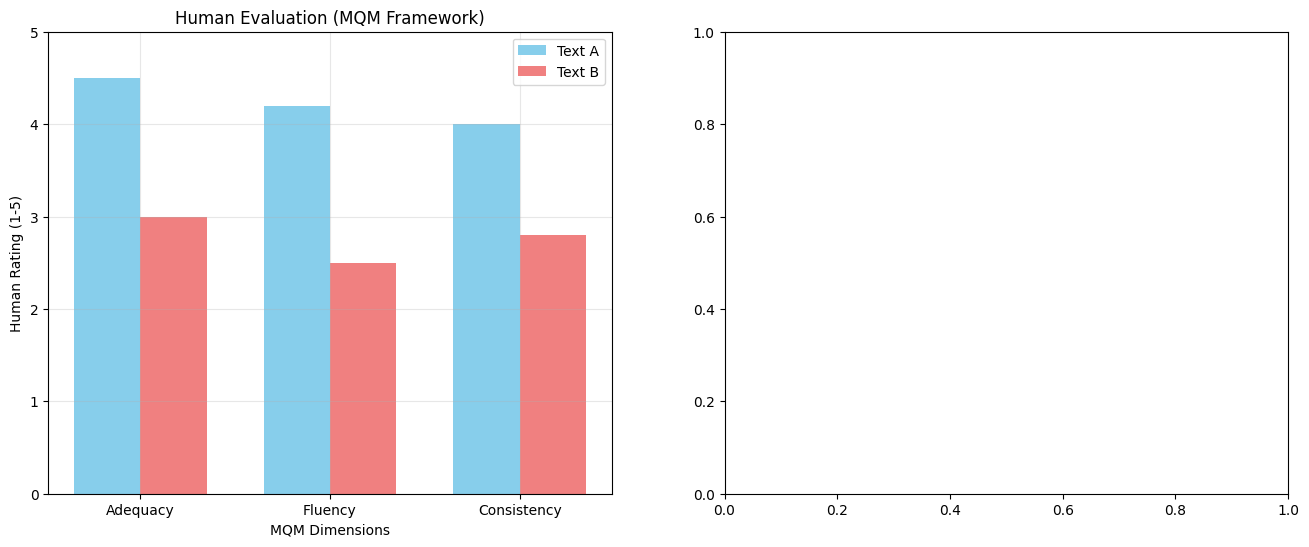

In [16]:
# The Final Visualization: Human vs Automatic Metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Human evaluation breakdown
human_metrics = ['Adequacy', 'Fluency', 'Consistency']
text_a_human = [text_a_adequacy, text_a_fluency, text_a_consistency]
text_b_human = [text_b_adequacy, text_b_fluency, text_b_consistency]

x = np.arange(len(human_metrics))
width = 0.35

ax1.bar(x - width/2, text_a_human, width, label='Text A', color='skyblue')
ax1.bar(x + width/2, text_b_human, width, label='Text B', color='lightcoral')
ax1.set_xlabel('MQM Dimensions')
ax1.set_ylabel('Human Rating (1-5)')
ax1.set_title('Human Evaluation (MQM Framework)')
ax1.set_xticks(x)
ax1.set_xticklabels(human_metrics)
ax1.legend()
ax1.set_ylim(0, 5)
ax1.grid(True, alpha=0.3)

# Automatic metrics comparison
auto_metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L', 'BERTScore', 'BLEURT*']
text_a_auto = [bleu_a, rouge_a['rouge1']['f1'], rouge_a['rougeL']['f1'], bert_a['f1'], bleurt_a]
text_b_auto = [bleu_b, rouge_b['rouge1']['f1'], rouge_b['rougeL']['f1'], bert_b['f1'], bleurt_b]

x2 = np.arange(len(auto_metrics))
ax2.bar(x2 - width/2, text_a_auto, width, label='Text A', color='skyblue')
ax2.bar(x2 + width/2, text_b_auto, width, label='Text B', color='lightcoral')
ax2.set_xlabel('Automatic Metrics')
ax2.set_ylabel('Score (0-1)')
ax2.set_title('Automatic Metrics Comparison')
ax2.set_xticks(x2)
ax2.set_xticklabels(auto_metrics, rotation=45)
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n🎯 THE AHA MOMENT:")
print("Compare the patterns between human ratings and automatic metrics:")
print(f"- Which automatic metric best matches your human judgment?")
print(f"- Where do the metrics disagree with human ratings?")
print(f"- What aspects do humans capture that automatic metrics miss?")

## Concluding Challenge: Your Own Evaluation Pipeline

**Task:** Choose a text generation scenario (translation, summarization, creative writing) and:

1. **Create 2-3 candidate outputs**
2. **Define appropriate references** (or gold standard)
3. **Apply all metrics:** BLEU, ROUGE, BERTScore, BLEURT, and human evaluation
4. **Analyze the results:** Which metrics agree? Which disagree? Why?
5. **Choose your evaluation strategy:** Which combination of metrics would you use for this task?

**Key Questions to Consider:**
- What aspects of quality matter most for your chosen task?
- Which metrics capture those aspects best?
- How would you combine automatic and human evaluation in practice?
- What are the trade-offs between speed, cost, and evaluation quality?

**Bonus Challenge:** Try implementing a simple ensemble metric that combines multiple automatic metrics. How does it correlate with human judgment?

---

### 🎓 Congratulations!

You've now experienced the full spectrum of generative AI evaluation:
- **N-gram metrics** for quick, reproducible evaluation
- **Embedding metrics** for semantic understanding
- **Learned metrics** for human-like judgment
- **Human evaluation** for nuanced quality assessment

**Remember:** The best evaluation strategy combines multiple perspectives. Choose your metrics based on your task, resources, and quality requirements!

*Keep experimenting, keep learning!* 🚀